# Data preperation
This notebook is primarily concerned with the preprocessing of the data and the derivation of a target attribute for the classification. Furthermore, dependencies between the target attribute and the channel title were examined.

## Preperation
Import the required packages and set global parameters.

In [147]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 16)

### Data preperation
The data is preprocessed at this point. This includes deriving new attributes from those in the data record. In addition, attributes whose values could not be interpreted as numerical or categorical were rejected because they are not suitable for predictions in this form.

Furthermore, the target value, the number of days a video needs until it is considered trending from publication, is calculated from the time of publication and the trending date.

In [148]:
df = pd.read_csv('../0_data/DEvideos.csv',
    low_memory=False)

df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

df['tags_count'] = df.apply(lambda row: len(row['tags'].split('|')), axis=1)
df['publish_hour'] = df['publish_time'].map(lambda x: x.hour)
df['publish_month'] = df['publish_time'].map(lambda x: x.month)
df['publish_year'] = df['publish_time'].map(lambda x: x.year)
df['publish_day_of_month'] = df['publish_time'].map(lambda x: x.day)
df['publish_weekday'] = df['publish_time'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday
df['trending_weekday'] = df['trending_date'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday

df['like_dislike_ratio'] = df.apply(lambda row: row['likes'] / (row['dislikes'] + 1), axis=1)
df['like_view_ratio'] = df.apply(lambda row: row['likes'] / (row['views'] + 1), axis=1)

df['ratings'] = df['likes'] + df['dislikes']
df['likes_per_rating'] = df['likes'] / df['ratings']
df['ratings_per_view'] = df['ratings'] / df['views']
df['comments_per_view'] = df['comment_count'] / df['views']

def assign_target_category(row):
    if row['days_until_trending'] == 0: 
        return '0 Days'
    elif row['days_until_trending'] == 1:
        return '1 Day'
    elif row['days_until_trending'] == 2:
        return '2 Days'
    elif row['days_until_trending'] <= 5:
        return '3 - 5 Days'
    else:
        return '> 5 Days'

df['target_category'] = df.apply(assign_target_category, axis=1)

N = len(df)
dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
for column in df.columns:
    numberOfUniqueValues = df[column].nunique()
    if numberOfUniqueValues < 2:
        dropColumns.append(column)
    elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
        dropColumns.append(column)
    elif df[column].isna().sum() / N > 0.95:
        dropColumns.append(column)
        
df.drop(columns=dropColumns, inplace=True)
df['channel_title'] = df['channel_title'].astype('category')
df['target_category'] = df['target_category'].astype('category')

### Data preview
Insight into the type and structure of the data.

In [149]:
df.head(10)

,trending_date,channel_title,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,...,publish_day_of_month,publish_weekday,trending_weekday,like_dislike_ratio,like_view_ratio,ratings,likes_per_rating,ratings_per_view,comments_per_view,target_category
0,2017-11-14,inscope21,24,2017-11-13 17:08:49,252786,35885,230,1539,False,False,...,13,0,1,155.346320,0.141957,36115,0.993631,0.142868,0.006088,1 Day
1,2017-11-14,LUKE! Die Woche und ich,23,2017-11-12 22:30:01,797196,53576,302,1278,False,False,...,12,6,1,176.818482,0.067205,53878,0.994395,0.067584,0.001603,2 Days
2,2017-11-14,LastWeekTonight,24,2017-11-13 07:30:00,2418783,97190,6146,12703,False,False,...,13,0,1,15.810965,0.040181,103336,0.940524,0.042722,0.005252,1 Day
3,2017-11-14,100SekundenPhysik,27,2017-11-12 15:00:01,380247,31821,458,1955,False,False,...,12,6,1,69.326797,0.083685,32279,0.985811,0.084890,0.005141,2 Days
4,2017-11-14,rezo,24,2017-11-12 13:10:36,822213,100684,2467,10244,False,False,...,12,6,1,40.795786,0.122455,103151,0.976084,0.125455,0.012459,2 Days
5,2017-11-14,Die Allestester,22,2017-11-13 01:49:24,32709,3093,296,63,False,False,...,13,0,1,10.414141,0.094558,3389,0.912659,0.103611,0.001926,1 Day
6,2017-11-14,Bodyformus,23,2017-11-13 11:59:04,308683,35704,578,1398,False,False,...,13,0,1,61.664940,0.115665,36282,0.984069,0.117538,0.004529,1 Day
7,2017-11-14,Jay & Arya,22,2017-11-13 18:09:55,181660,17998,169,554,False,False,...,13,0,1,105.870588,0.099075,18167,0.990697,0.100006,0.003050,1 Day
8,2017-11-14,TeddyComedy,23,2017-11-12 11:53:45,369173,16953,570,611,False,False,...,12,6,1,29.690018,0.045921,17523,0.967471,0.047466,0.001655,2 Days
9,2017-11-14,WALULIS,1,2017-11-13 15:06:12,62418,4749,44,425,False,False,...,13,0,1,105.533333,0.076083,4793,0.990820,0.076789,0.006809,1 Day


## Derive categories
At this point the procedure for deriving the target attribute is explained.

### Days until trending
Before an attribute can be created for classification, the target variable itself must first be calculated and analyzed. The goal of the predictions is to determine the number of days until a video is trending after its release.

The first insight into the target size already indicates that a very large proportion of the videos are trending after a day or two. Outliers range up to over 2000 days between publication and the trending status.

In [150]:
df['days_until_trending'].describe()

count    40840.000000
mean         1.850416
std         19.621604
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2046.000000
Name: days_until_trending, dtype: float64

In order to analyze the distribution more precisely, the following graphic representation shows the distribution of the videos over the number of days until the trending status. It is very noticeable that more than 6 days between publication and trending status occurs very rarely and that over half of the videos are considered trending after exactly one day or, more correctly, the day after publication.

<AxesSubplot:xlabel='days_until_trending', ylabel='count'>

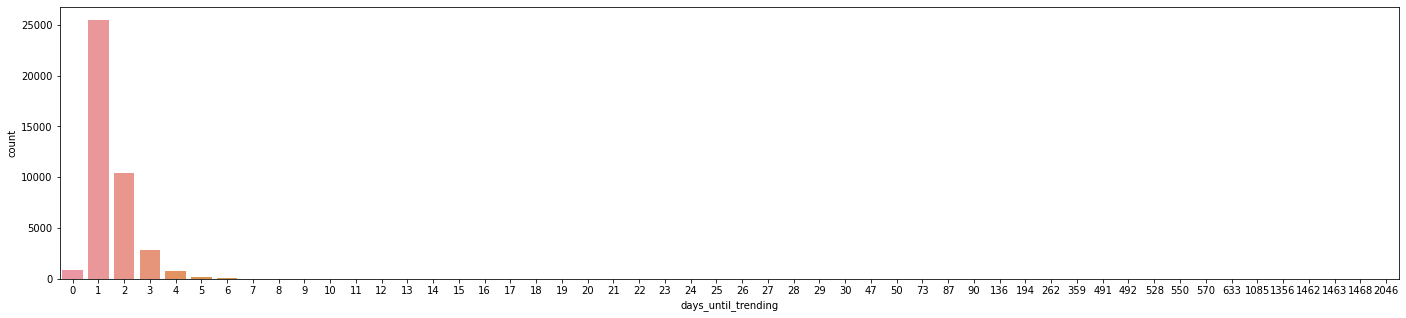

In [151]:
plt.rcParams['figure.figsize'] = (24, 5)
sns.countplot(data=df, x='days_until_trending')

In [152]:
dfperc = df['days_until_trending'].value_counts()
dfperc = dfperc.apply(lambda x: ( x / len(df) ) * 100).round(2)
dfperc = dfperc.sort_index(ascending=True)
dfperc.head()

0     2.05
1    62.38
2    25.63
3     6.95
4     1.79
Name: days_until_trending, dtype: float64

<AxesSubplot:xlabel='days_until_trending', ylabel='percent'>

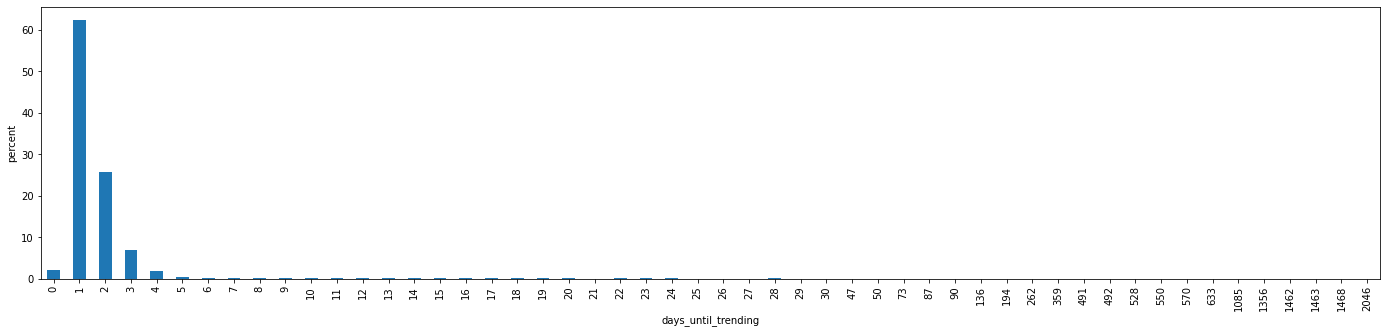

In [153]:
dfperc.plot.bar(xlabel='days_until_trending', ylabel='percent')

For a more specific derivation of the target categories, the view in the following graph was limited to those numbers of days until the trending status was reached, which represented at least 0.1 percent of the videos. This left the periods of zero to six days between the video publication and the trending status.

,trending_date,channel_title,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,...,publish_day_of_month,publish_weekday,trending_weekday,like_dislike_ratio,like_view_ratio,ratings,likes_per_rating,ratings_per_view,comments_per_view,target_category
0,2017-11-14,inscope21,24,2017-11-13 17:08:49,252786,35885,230,1539,False,False,...,13,0,1,155.346320,0.141957,36115,0.993631,0.142868,0.006088,1 Day
1,2017-11-14,LUKE! Die Woche und ich,23,2017-11-12 22:30:01,797196,53576,302,1278,False,False,...,12,6,1,176.818482,0.067205,53878,0.994395,0.067584,0.001603,2 Days
2,2017-11-14,LastWeekTonight,24,2017-11-13 07:30:00,2418783,97190,6146,12703,False,False,...,13,0,1,15.810965,0.040181,103336,0.940524,0.042722,0.005252,1 Day
3,2017-11-14,100SekundenPhysik,27,2017-11-12 15:00:01,380247,31821,458,1955,False,False,...,12,6,1,69.326797,0.083685,32279,0.985811,0.084890,0.005141,2 Days
4,2017-11-14,rezo,24,2017-11-12 13:10:36,822213,100684,2467,10244,False,False,...,12,6,1,40.795786,0.122455,103151,0.976084,0.125455,0.012459,2 Days


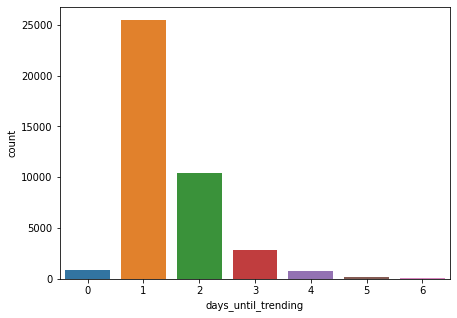

In [154]:
plt.rcParams['figure.figsize'] = (7, 5)
df2 = df.groupby('days_until_trending').filter(lambda x: len(x) >= len(df.index) / 1000)
sns.countplot(data=df2, x='days_until_trending')
df.head()

### Target category
Several categories for the classification were then derived from the previous distribution of the days up to the trending status.

The following classes were defined:
- ``0 days`` The video is already trending on the day it is released.
- ``1 day`` The video is considered trending the day after it is released. This is by far the largest class.
- ``2 days`` The video is considered trending two days after it was published.
- ``3-5 days`` The video is trending within the first five days after publication (without fulfilling any of the previous categories).
- ``> 5 days`` All remaining.

In [155]:
df['target_category'].describe()

count     40840
unique        5
top       1 Day
freq      25474
Name: target_category, dtype: object

The following figure shows the distribution with regard to the target classes. The proportion for the marginal classes is noticeably low, while the "1 day" class contains over half of the data records.

<AxesSubplot:xlabel='target_category', ylabel='count'>

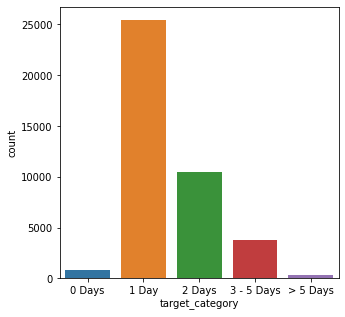

In [156]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.countplot(data=df, x='target_category')

## Correlation between channel title and target attribute.
The correlation analysis revealed an increased relationship between the channel title and the target category. With this in mind, the correlation is examined in more detail in the following diagrams. However, as the project progressed, other attributes turned out to be better feature candidates for the predictions.

*In the following, only channels are considered, which are responsible for at least 0.2 percent of the videos within the data set, in order to limit the observation.*

The first graph shows the number of videos per channel.

<AxesSubplot:xlabel='count', ylabel='channel_title'>

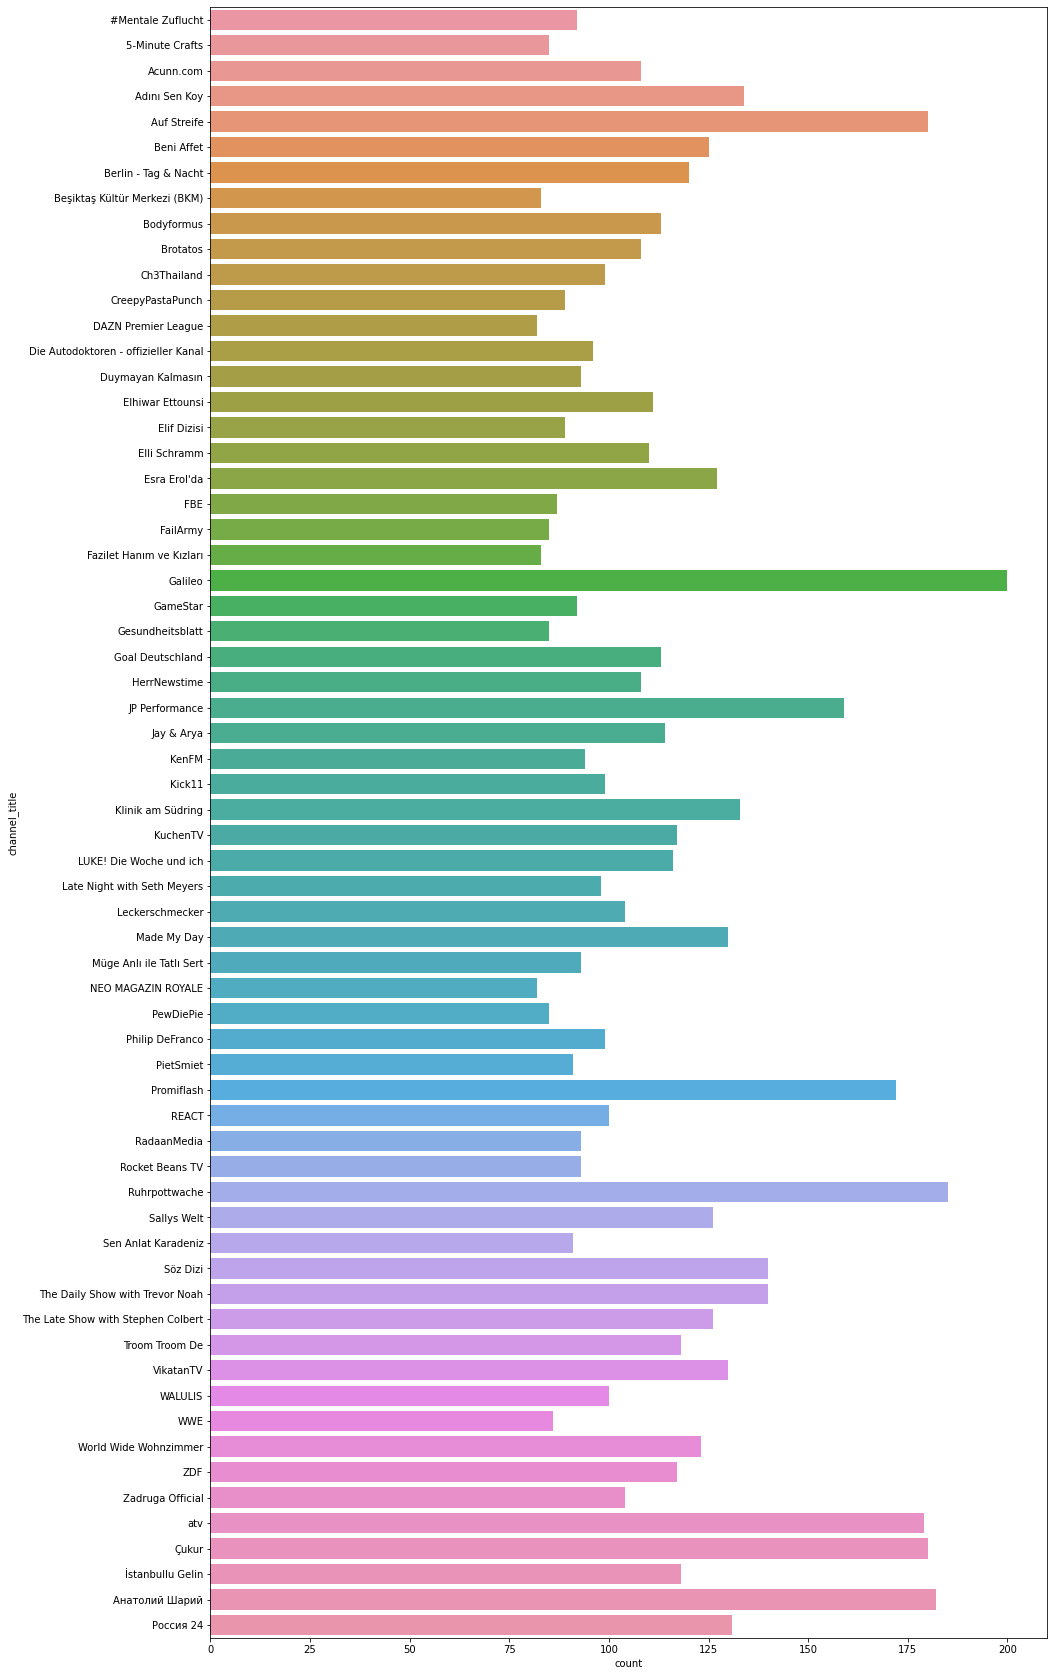

In [157]:
plt.rcParams['figure.figsize'] = (15, 30)
df2 = df.groupby('channel_title').filter(lambda x: len(x) >= len(df.index) / 500)
df2.channel_title = df2.channel_title.cat.remove_unused_categories()
sns.countplot(data=df2, y='channel_title', orient='h')

For each of these channels, it is then shown which target classes the videos of the channel fall into and to what extent. This correlation is shown in three different visualizations. Although a correlation between the channel and the distribution of the videos in the target classes is clearly visible, other attributes such as the number of views, the time of publication or the ratio of ratings to views turned out to be better candidates for the features of the predictions.

<AxesSubplot:xlabel='count', ylabel='channel_title'>

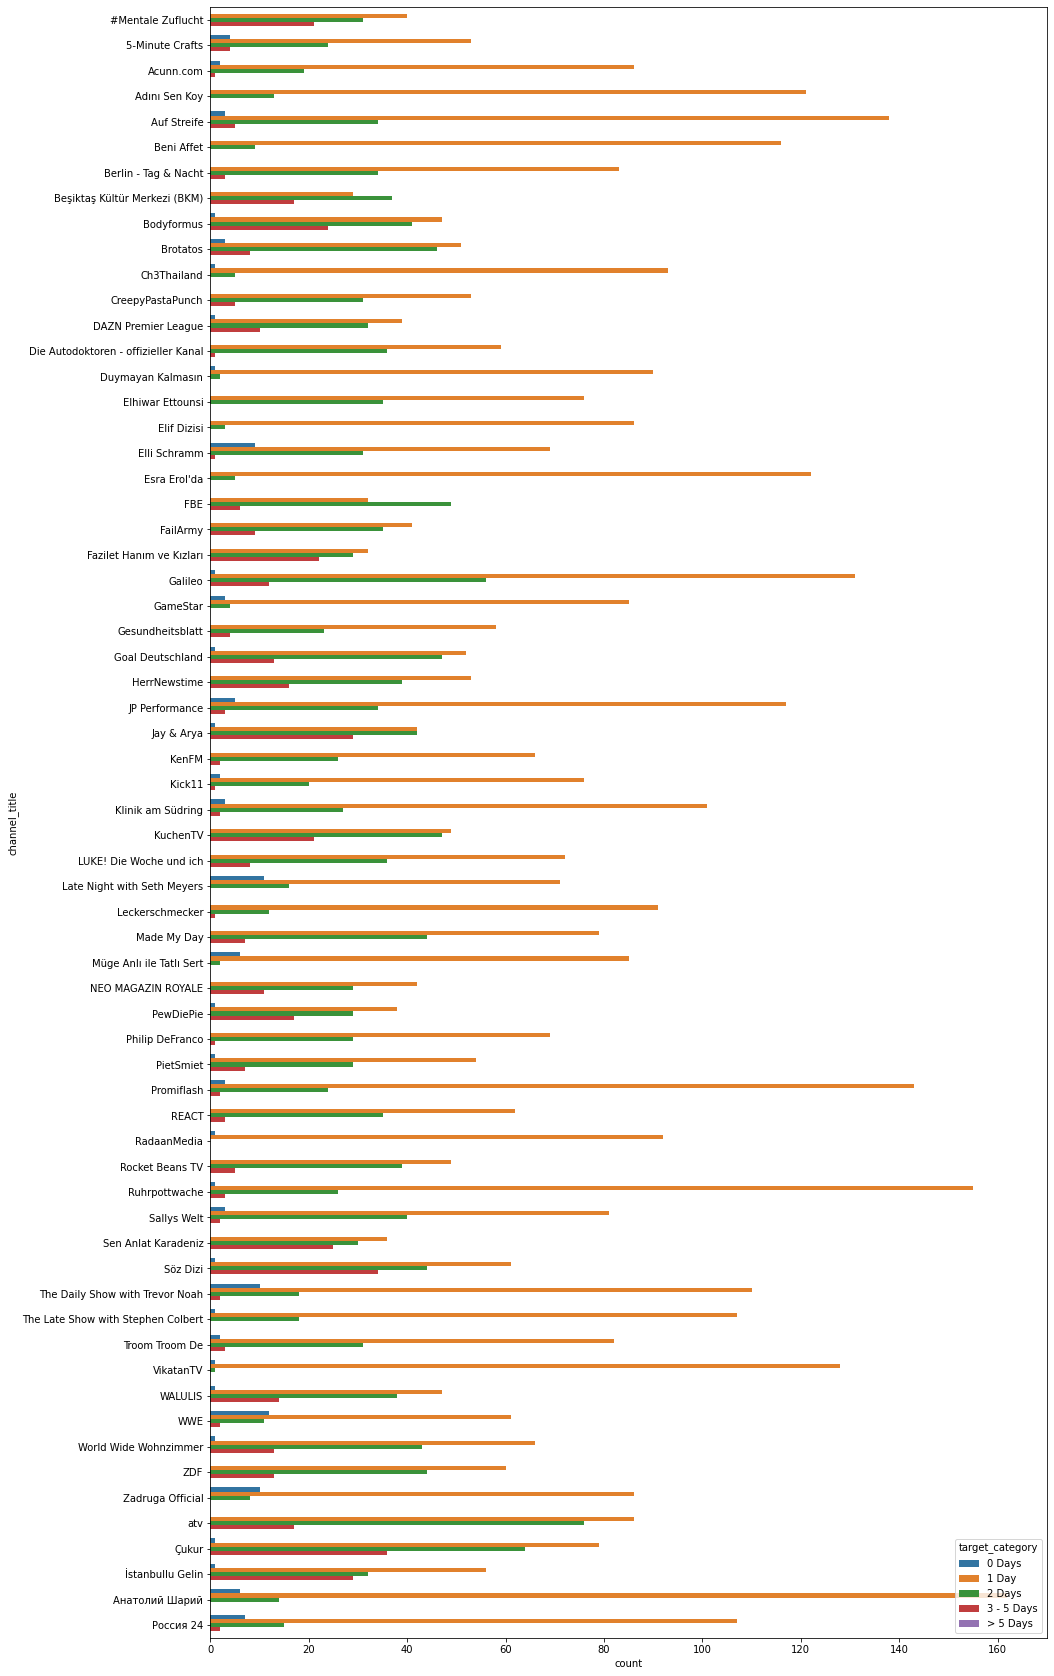

In [158]:
plt.rcParams['figure.figsize'] = (15, 30)
sns.countplot(data=df2, y='channel_title', hue='target_category')

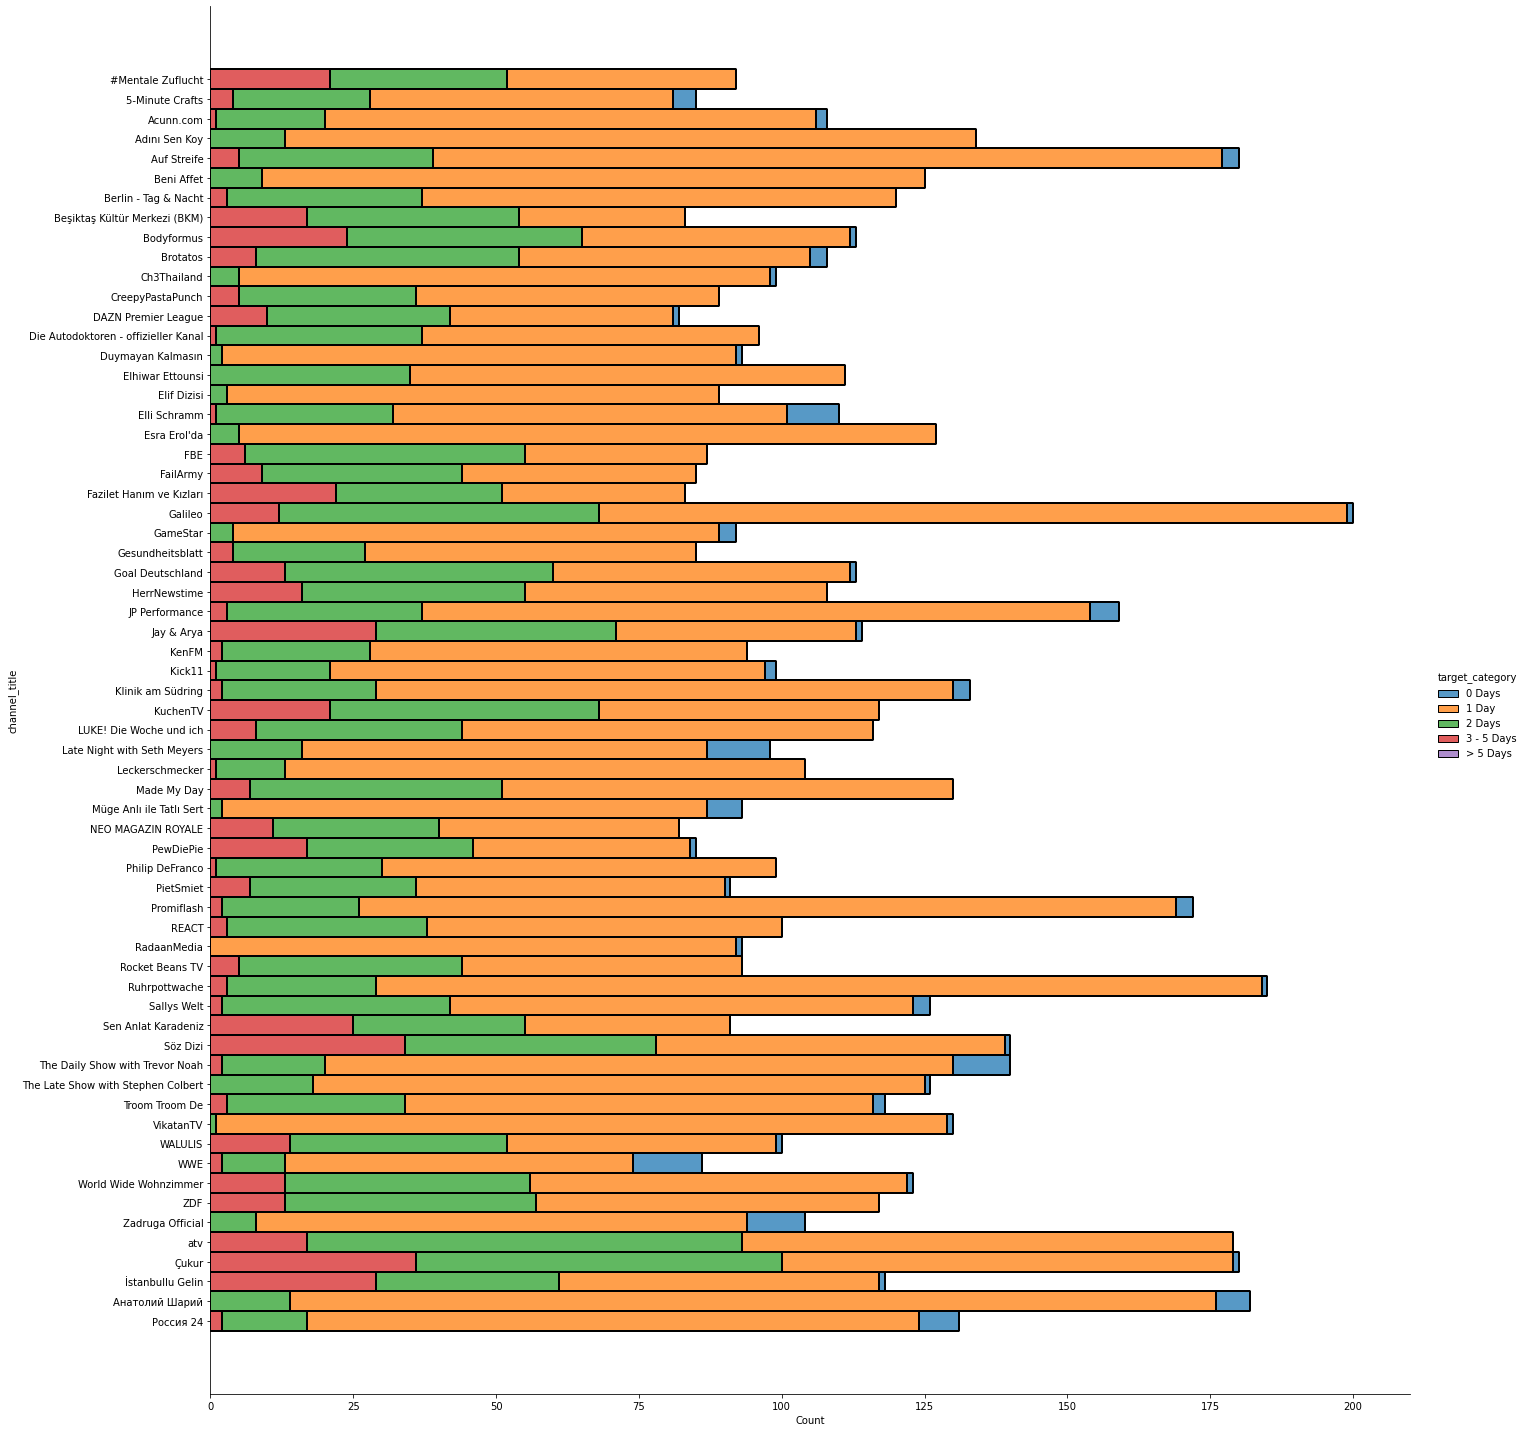

In [159]:
sns.displot(data=df2, y='channel_title', hue='target_category', multiple='stack', height=20)

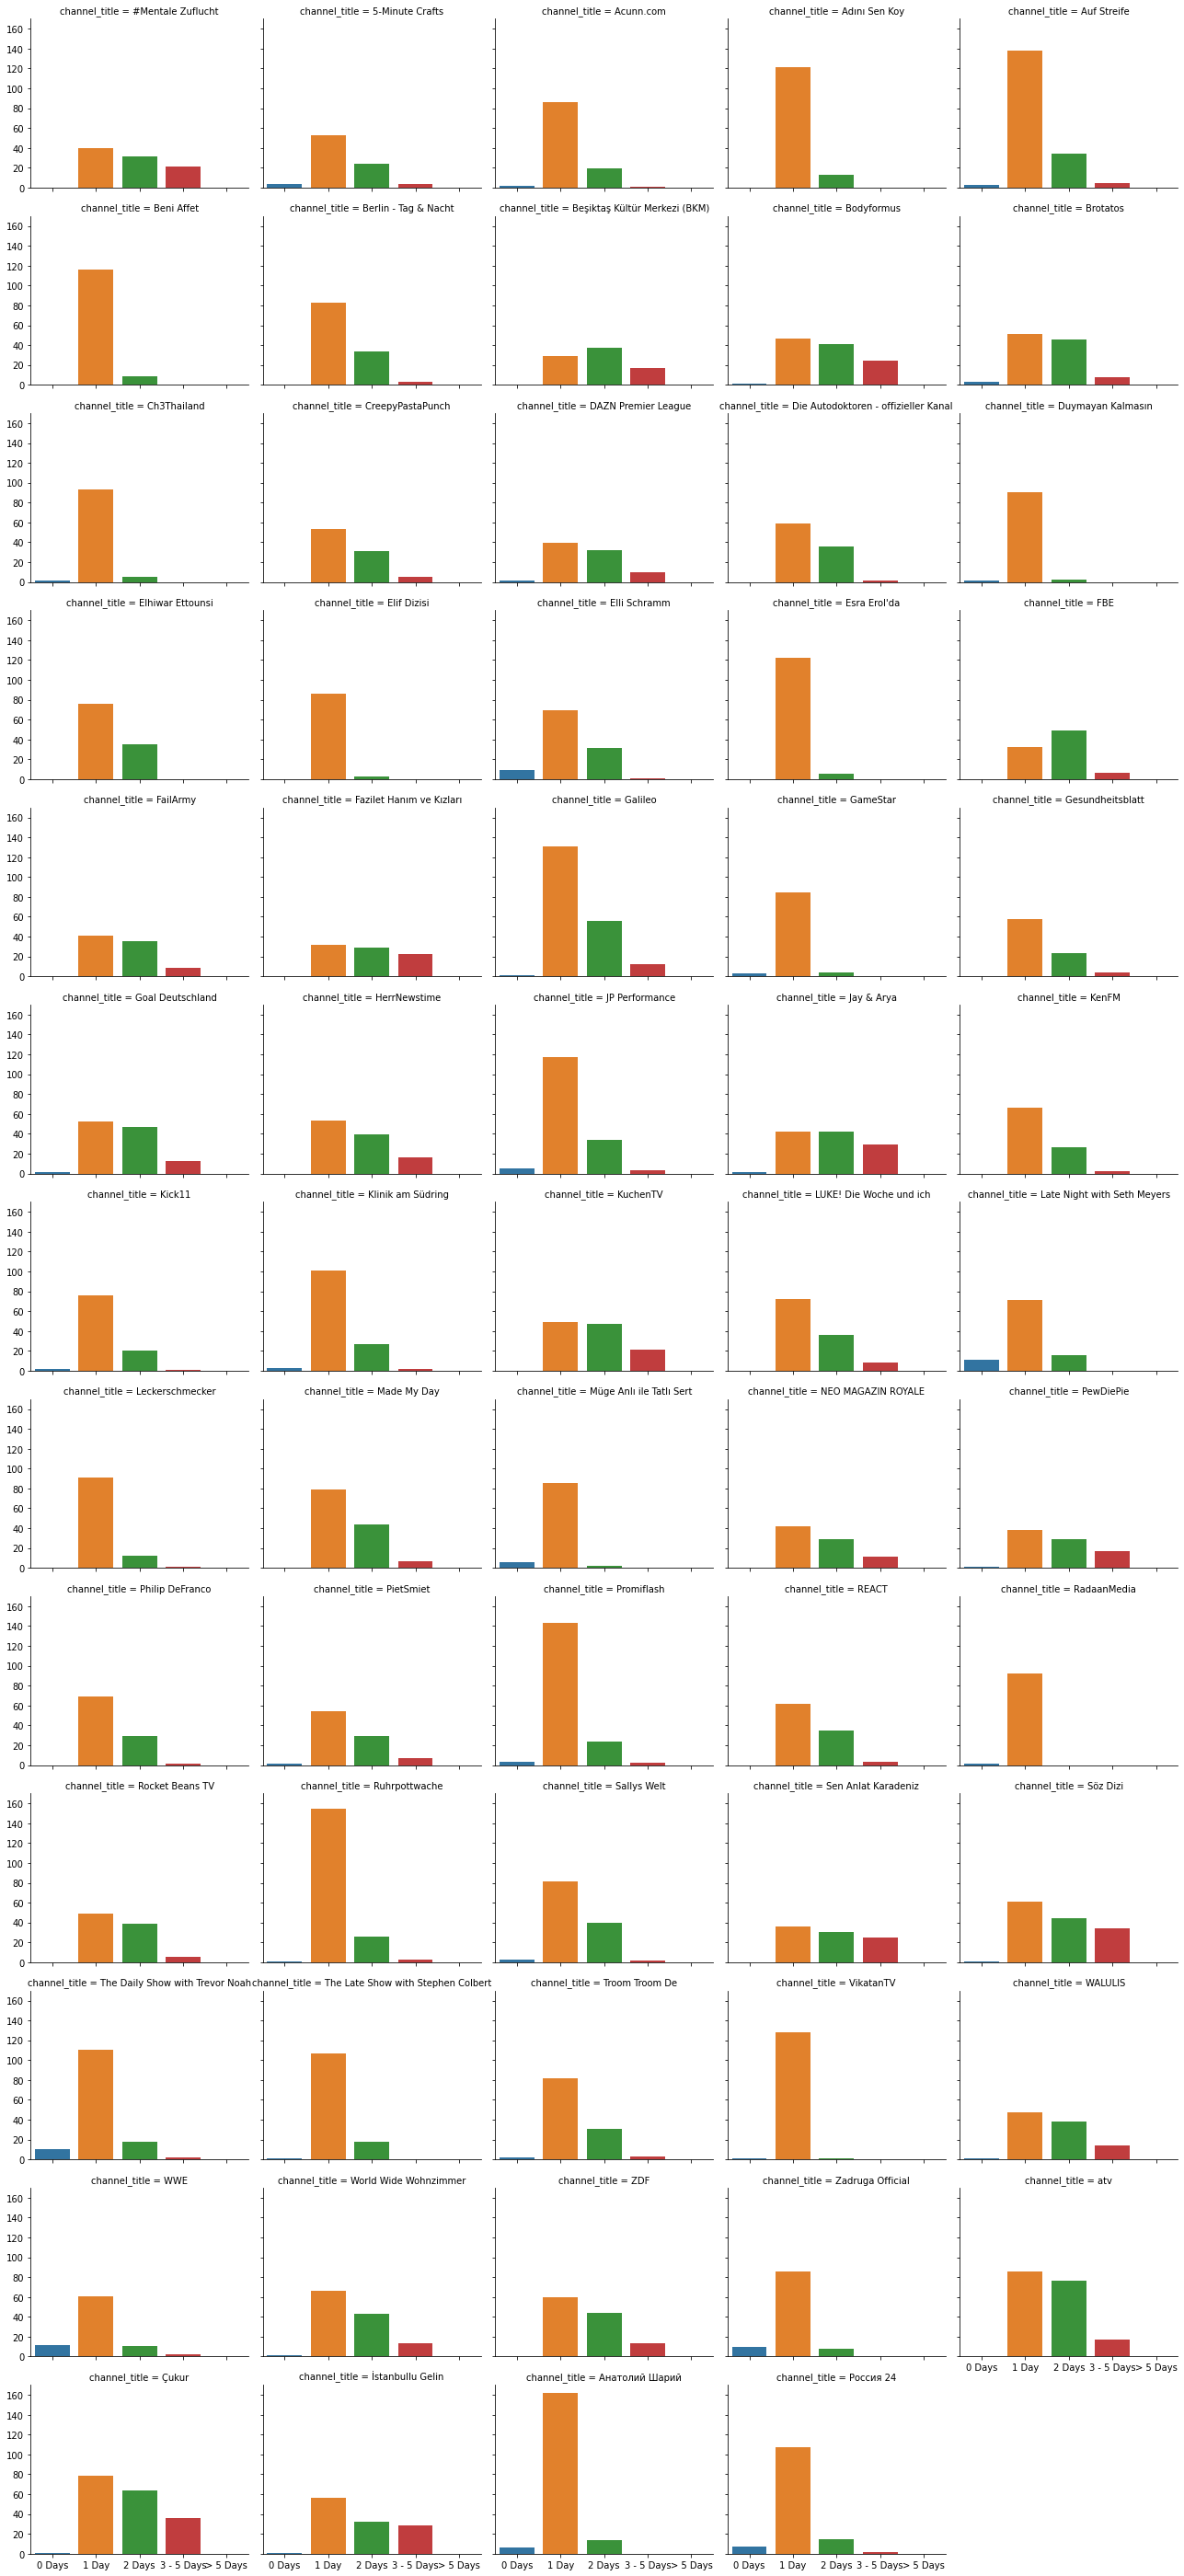

In [160]:
graph = sns.FacetGrid(data=df2, col='channel_title', col_wrap=5, height=3, aspect=1.2)
graph.map_dataframe(sns.countplot, x='target_category', palette=sns.color_palette())